
<h1>
    <center>
        <span style="font-family:Arial">
            Imagerie Numérique
        </span>
    </center>
</h1>
<h2>
    <center>
        <span style="font-family:Arial">
            Image Fusion with Guided Filtering
        </span>
    </center>
</h2>
MVA 2021,
Gabriel Belouze & Raphaël Rozenberg

# Setup

In [ ]:
LOCATION = "colab" if False else "local" # change this line

BASE_DIR = "mva-imagerie-numerique" if LOCATION == "colab" else ".."

In [ ]:
# Only run this cell on colab
# Locally, we suggest instead to make a new python virtual environment and run
# 
# pip install -r requirements.txt
# pip install -e .
#
# Don't forget to change the kernel of the notebook to use this virtual env.

if LOCATION == "colab":
    !git clone https://github.com/gbelouze/mva-imagerie-numerique
    !pip install mva-imagerie-numerique/
# if you get a warning from colab saying that some packages were previously imported and
# that the environment must be restarted, click on "restart environment" and
# run this cell again, it should go smoothly the second time.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
import cv2
from scipy.ndimage import gaussian_filter as gaussian
from pathlib import Path

# Our own implementation
import gf
import gf.filters as filters
import gf.data as data
import gf.fusion as fusion
import gf.recalage as recalage

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.titlesize'] = 'small'

# Preliminaries <a class="anchor" id="preliminaries"></a>

## Load data

**Datasets we used:**

- *Petrovic*: grayscale multi-focus dataset, by pairs of pictures 

Petrovic V, "Subjective Tests for Image Fusion Evaluation and Objective Performance Metric Validation", Information Fusion, vol. 8, April 2007, pp. 208-216.

- *Lytro*: color multi-focus dataset, mostly by pairs

M. Nejati, S. Samavi, S. Shirani, "Multi-focus Image Fusion Using Dictionary-Based Sparse Representation", Information Fusion, vol. 25, Sept. 2015, pp. 72-84.

- *MEFDatabase*: color multi-exposure dataset, several pictures each time

Kede Ma, Kai Zeng and Zhou Wang, "Perceptual Quality Assessment for 
Multi-Exposure Image Fusion," IEEE Trans. on Image Processing (TIP), 2015.

- Our own pictures: multi-focus, several pictures each time

Credits to Gabriel Belouze :)

In [ ]:
multi_exposure_dataset = data.MultiviewDataset(Path(f"{BASE_DIR}/data/MEFDatabase/source/"))
multi_focus_dataset = data.MultiviewDataset(Path(f"{BASE_DIR}/data/lytro"))
ours_dataset = data.MultiviewDataset(Path(f"{BASE_DIR}/data/ours"))

multi_exposure_sample = multi_exposure_dataset["Balloons_Erik Reinhard"]
multi_exposure_sample = multi_exposure_dataset["Lighthouse_HDRsoft"]
multi_focus_sample = multi_focus_dataset["20"]
ours_sample = ours_dataset["stylos2"]


gray_sample = [iio.imread(path) / 255 for path in [f"{BASE_DIR}/data/petrovic/input001_{i}.tif" for i in (1, 2)]]

## Show data

In [ ]:
def gray_to_rgb(im):
    return np.stack([im, im, im], axis=-1)

def plot_images(*ims, maxwidth=5, labels=None, title=""):
  max_ndim = max([im.ndim for im in ims])
  if max_ndim == 3:
      ims = [im if im.ndim == 3 else gray_to_rgb(im) for im in ims]
  else:
      ims = [im for im in ims]

  n = len(ims)
  nrows, ncols = (n-1)//maxwidth + 1, min(maxwidth, n)
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False)
  if labels is None:
      labels = [None] * n
  for ind, (label, im) in enumerate(zip(labels, ims)):
      ax = axs[ind // ncols, ind % ncols]
      ax.imshow(im, cmap=plt.gray())
      if label is not None:
          ax.set_title(label)
      ax.set_axis_off()
  fig.subplots_adjust(wspace=0, hspace=0)
  fig.suptitle(title)

From *MEFDatabase* dataset:

In [ ]:
plot_images(*multi_exposure_sample)

From *Lytro* dataset:

In [ ]:
plot_images(*multi_focus_sample)

Our own pictures:

In [ ]:
plot_images(*ours_sample, maxwidth=4)

From *Petrovic* dataset:

In [ ]:
plot_images(*gray_sample)

# Guided filtering <a class="anchor" id="guided-filtering"></a>

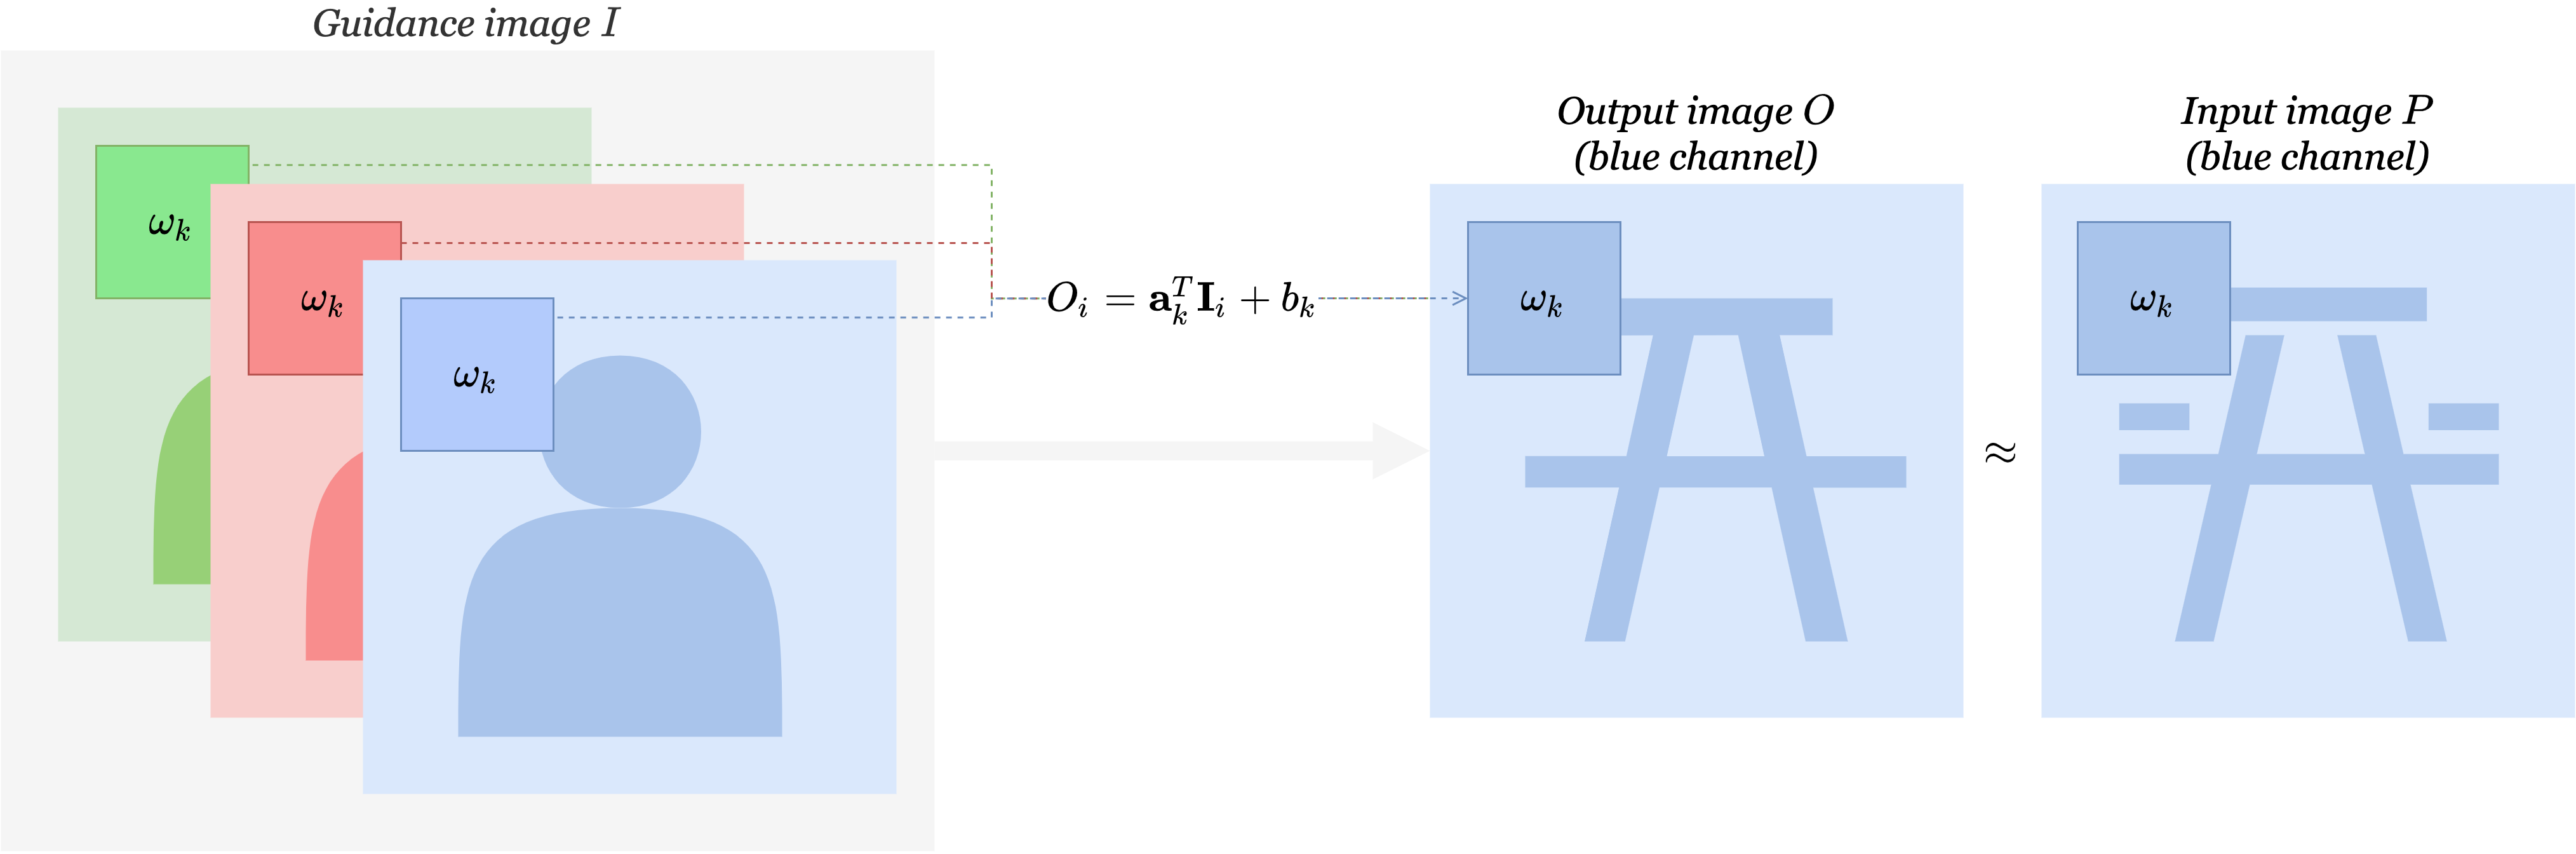

Guided filtering is a smoothing method which tries to respect image structure (and most notably edges). In this regard, it resembles bilateral filtering. However, guided filtering is able to preserve edges of *another* image.  
Guided filtering takes two images, $P$ and $I$ as inputs and produces one image $O$ as output.
- $P$ is called the input image. $O$ is designed to look like $P$.
- $I$ is called the guidance image. $O$ is structured like $I$ in that it should share the same edges.

Concretely speaking, to produce $O_i$ the output at pixel $i$, we look at $w_i$ a window centered at $i$. We try to construct an affine transformation of the corresponding window in $I$, so that the window produces looks like the corresponding window in $P$. This means that we minimize over $a_i$ and $b_i$ the energy
$$ E(a_i, b_i) = \sum_{k \in w_i} ( a_i I_k + b_i - P_k)^2 + \varepsilon a_i^2$$
where we added a regularisation term $\varepsilon a_i^2$.

There are some additional details :
- if $I$ is RGB, we look at $\mathbf{a}_i^T \mathbf{I}_i$ instead
- if $P$ is RGB, we realize 3 filtering for the 3 $P$ channels

In our case, $I$ will be RGB and $P$ gray.

## Gray guide <a class="anchor" id="gf:gray-guide"></a>

In [ ]:
input = multi_focus_sample[0].mean(axis=-1)
guide = multi_focus_sample[1].mean(axis=-1)
output = filters.guided_filter(input, guide, r=20, eps=5e-2)

In [ ]:
plot_images(input, guide, output, 
            labels=['input 1', 'input 2', 'output'])

Notably, the edges of the buildings in the backgrounds remain sharp.

## RGB guide <a class="anchor" id="gf:rgb-guide"></a>

In [ ]:
input = multi_focus_sample[0]
guide = multi_focus_sample[1]
output = filters.guided_filter(input, guide, r=20, eps=5e-2)

In [ ]:
plot_images(input, guide, output, 
            labels=['input', 'guide', 'filter output'])

# Image fusion with guided filtering <a class="anchor" id="image-fusion"></a>

The method aims at combining several images, either in a multi-focus setting or in a multi-exposure setting.

The images are combined through a weighted sum. The weights are determined according to the saliency map of each image, which measures the level of spatial variation at each pixel. In addition, the method aims at leveraging structural information, especially by preserving edges as much as possible thanks to guided filtering.

This method can be used indifferently for multi-focus and multi-exposure problems because in both cases, the saliency map is a relevant quantity. Indeed, in the multi-focus setting, images are salient where they are sharp, whereas in the multi-exposure setting they are salient where they are well-exposed.

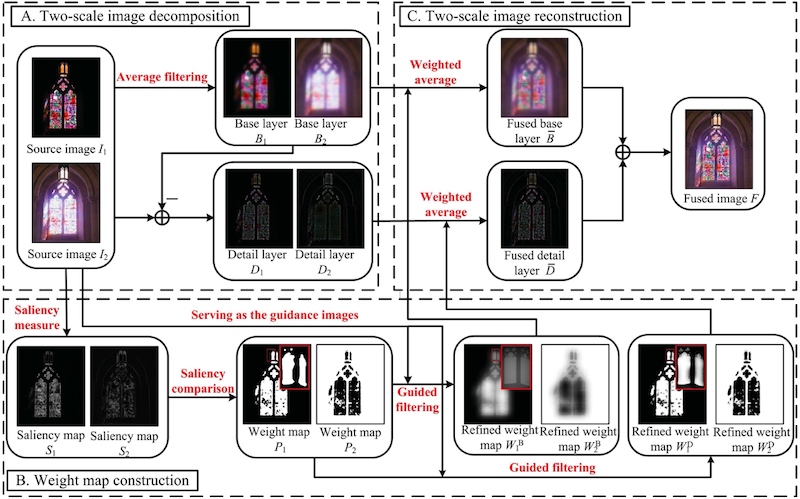

## Step by step <a class="anchor" id="fusion:step-by-step"></a>

In [ ]:
gff_focus = fusion.gff(multi_focus_sample)

### Weight map
Weight maps are constructed to be $1$ at pixel $i$ if the image has the highest saliency (i.e. gradient norm) at pixel $i$, and $0$ otherwise.

In [ ]:
plot_images(*gff_focus.weights, 
            labels=['weight map 1', 'weight map 2'])
plt.show()

### Base / Detail decomposition
Then, images are split into a base layer and a detail layer. Each layer will have its own weight map and be fused back in only at the very end.

In [ ]:
base_layer, detail_layer = zip(*[gff_focus.decompose(im) for im in gff_focus.ims])
plot_images(*base_layer, 
            labels=['base 1', 'base 2'])
plt.show()
plot_images(*detail_layer, 
            labels=['details 1', 'details 2'])
plt.show()

### Refined weight map
The key idea is to use guided filtering with the original image as guidance. This mitigates noise and edge-aligns weight maps. 

Different parameters (see below) are used to get distinct weight maps for the base and details layers. In general, a larger window size, and a larger regularisation $\varepsilon$ are used for the base layer.

In [ ]:
fused_focus = gff_focus.fusion()
plot_images(*gff_focus.refined_weights["base"], 
            labels=['refined weight map 1 (for base)', 'refined weight map 2 (for base)'])
plt.show()
plot_images(*gff_focus.refined_weights["detail"], 
            labels=['refined weight map 1 (for details)', 'refined weight map 2 (for details)'])
plt.show()

### Fusion
Those refined weight maps are used to fuse images in each layer base and details). Finally, the layers are added up to produce a single final image.  
For multi-focus, the base fusion is not that important as the base images basically look the same (a blurry version of the scene). However, for HDR, both base fusion and detail fusion must be done carefully.

In [ ]:
plot_images(gff_focus.fused["base"], gff_focus.fused["detail"], fused_focus, 
            labels=['fused bases', 'fused details', 'final result'])
plt.show()

## Examples <a class="anchor" id="fusion:examples"></a>

Because the concept of *saliency* discriminates both in-focus against out-of-focus, and saturated against non-saturated, the method above can actually be used both for HDR and multi-focus recomposition.

In [ ]:
exposure_gff = fusion.gff(multi_exposure_sample)
multi_exposure_fused = exposure_gff.fusion(r1=100, r2=15)

focus_gff = fusion.gff(multi_focus_sample)
multi_focus_fused = focus_gff.fusion()

gray_gff = fusion.gff(gray_sample)
multi_gray_fused = gray_gff.fusion()

In [ ]:
plot_images(*multi_exposure_sample, multi_exposure_fused, 
            labels=['input 1', 'input 2', 'input 3', 'result'])
plt.show()

plot_images(*multi_focus_sample, multi_focus_fused, 
            labels=['input 1', 'input 2', 'result'])
plt.show()

plot_images(*gray_sample, multi_gray_fused, 
            labels=['input 1', 'input 2', 'result'])
plt.show()

## Managing out-of-bounds values

The authors do not speak about how to handle out of bounds values. Out-of-bounds may appear during two steps:

1. When applying the **guided filters**, there is no guarantee that the output will stay either in the input image or guidance image bounds. It seems reasonable to clip the filtered weights between 0 and 1, otherwise we cannot normalize the weights in a meaningful way.

2. When **recombining** the base and detail layer, we can also get out-of-bounds values. Simply rescaling the output may noticeably "grayify" the image if there are values in the output too far out of bounds. We chose to also clip the image instead.

# Experiments and remarks

## Parameters and their impact




The choice of parameters can be crucial, especially for multi-exposure fusion. This is less the case for multi-focus fusion.

The article is contrasted about this issue, stating at first:

> "the GFF
method does not depend much on the exact parameter choice."

However, the article ends with 

> "adaptively choosing the parameters of the guided
filter can be further researched."

which indicates that the question cannot be entirely dismissed, especially for multi-exposure fusion.


In [ ]:
multi_exposure_sample = multi_exposure_dataset["Lighthouse_HDRsoft"]
plot_images(*multi_exposure_sample,
            labels=['input 1', 'input 2', 'input 3'])
plt.show()

In [ ]:
exposure_gff = fusion.gff(multi_exposure_sample)

multi_exposure_fused = exposure_gff.fusion(r1=100, r2=15, eps1=0.3, eps2=1e-6)
multi_exposure_fused_1 = exposure_gff.fusion(r1=3, r2=15, eps1=0.3, eps2=1e-6)
multi_exposure_fused_2 = exposure_gff.fusion(r1=1000, r2=15, eps1=0.3, eps2=1e-6)
multi_exposure_fused_3 = exposure_gff.fusion(r1=100, r2=15, eps1=1e-6, eps2=1e-6)
multi_exposure_fused_4 = exposure_gff.fusion(r1=100, r2=15, eps1=100, eps2=1e-6)

plot_images(multi_exposure_fused,
            labels=['good fusion'])
plt.show()
plot_images(multi_exposure_fused_1, multi_exposure_fused_2,
            labels=['smaller window (base layer)', 'bigger window (base layer)'])
plt.show()
plot_images(multi_exposure_fused_3, multi_exposure_fused_4,
            labels=['less regularization (base layer)', 'more regularization (base layer)'])
plt.show()

Modifying the value of either $r$ (the window size) or $\epsilon$ (the regulaization parameter) in **the base layer parameters** induces important defects.

- Top row (window size $r$): **patches appear when $r$ is too small**, and many zones are too light when $r$ is too big (averaging on wide zones).


- Bottom row (regularization parameter $\epsilon$): **incoherent result with insufficient regularization**: the house seems flat, the beach is much lighter than the sea, etc. However increasing regularization has little effect.

In [ ]:
multi_exposure_fused_1 = exposure_gff.fusion(r1=100, r2=1, eps1=0.3, eps2=1e-6)
multi_exposure_fused_2 = exposure_gff.fusion(r1=100, r2=500, eps1=0.3, eps2=1e-6)
multi_exposure_fused_3 = exposure_gff.fusion(r1=100, r2=15, eps1=0.3, eps2=1e-10)
multi_exposure_fused_4 = exposure_gff.fusion(r1=100, r2=15, eps1=0.3, eps2=1e2)

plot_images(multi_exposure_fused,
            labels=['good fusion'])
plt.show()
plot_images(multi_exposure_fused_1, multi_exposure_fused_2,
            labels=['smaller window (detail layer)', 'bigger window (detail layer)'])
plt.show()
plot_images(multi_exposure_fused_3, multi_exposure_fused_4,
            labels=['less regularization (detail layer)', 'more regularization (detail layer)'])
plt.show()

Most changes are less noticeable when toying with the **details layer parameters**, probably because the layer is more sparse.

- Top row ($r$) : once again, patches appear when $r$ is too small (even though less noticeably), but more importantly **details are lost when $r$ is too big**.


- Bottom row ($\epsilon$): no noticeable changes.

## Is guided filtering necessary?

The authors suggest guided filtering as a filter method which knows about the structure of the (source/guide) image, and specifically its edges. We investigated how useful this method was against:
- no-filtering
- a naive gaussian filter

### No filtering

It is necessary to perform some kind of smoothing, in order to prevent patches to appear. This can be easily seen in the case of exposure fusion: 

In [ ]:
# no weights filtering
fused_exposure = exposure_gff.fusion(filt=lambda p, *args, **kwargs: p)
plot_images(*multi_exposure_sample)
plot_images(*exposure_gff.normalised_refined_weights["base"]) #same as detail
plt.show()
plot_images(fused_exposure)

### Gaussian filtering

What about using a gaussian filter instead of a guided filter that leverages the structure of a guidance image?

In [ ]:
def gaussian_filter(p,i,r,eps):
  return gaussian(p, r)

In [ ]:
multi_exposure_sample = multi_exposure_dataset["Memorial_Debevec97"]
exposure_gff = fusion.gff(multi_exposure_sample)
plot_images(*multi_exposure_sample, maxwidth=4)

In [ ]:
# Guided filter with source image as guide
fused_exposure = exposure_gff.fusion(r1=20, eps1=1e-2)

plot_images(*exposure_gff.normalised_refined_weights["base"],
            title="Guided filter: Refined weights [Base layer]",
            maxwidth=4)
plt.show()
plot_images(*exposure_gff.normalised_refined_weights["detail"],
            title="Guided filter: Refined weights [Detail layer]",
            maxwidth=4)
plt.show()

In [ ]:
# Gaussian filter
fused_exposure_gauss = exposure_gff.fusion(filt=gaussian_filter,
                                           r1=10)

plot_images(*exposure_gff.normalised_refined_weights["base"],
            title="Gaussian filter: Refined weights [Base layer]",
            maxwidth=4)
plt.show()
plot_images(*exposure_gff.normalised_refined_weights["detail"],
            title="Gaussian filter: Refined weights [Detail layer]",
            maxwidth=4)
plt.show()

In [ ]:
plot_images(fused_exposure_gauss, fused_exposure,
            labels=['Gaussian filtering fusion', 'Guided filtering fusion'])

Gaussian filtering yields less satisfying results than guided filtering, especially in the most difficult zones (here around the stained glasses).

However, it is **much** faster, so in terms of real life applications it might be more useful.

## Base/detail separation



The base / detail separation is only useful to use different guidance parameter for the guided filtering. However, as shown *figure 8* of the article, the dependance to those parameters seems minimal.

Here we show that in most cases (but not all), it seems that the base/detail separation is actually not necessary. In several examples below, the results are extremely similar (in fact indistinguishable to the naked eye) when using or not base/details separation:

In [ ]:
multi_focus_sample = multi_focus_dataset["20"]
focus_gff = fusion.gff(multi_focus_sample)
multi_focus_fused = focus_gff.fusion()
multi_focus_fused_no_sep = focus_gff.fusion_without_separation(r=20)


plot_images(*multi_focus_sample,
            labels=['input 1', 'input 2'])
plt.show()

plot_images(multi_focus_fused, multi_focus_fused_no_sep,
            labels=["Base-Detail separation", "No separation"])
plt.show()

In [ ]:
multi_exposure_sample = multi_exposure_dataset["Memorial_Debevec97"]
plot_images(*multi_exposure_sample, maxwidth=4,
            title = "input pictures")
plt.show()

In [ ]:
exposure_gff = fusion.gff(multi_exposure_sample)

multi_exposure_fused = exposure_gff.fusion(r1=20, eps1=1e-2)
multi_exposure_fused_no_sep = exposure_gff.fusion_without_separation(r=20, eps=1e-2)

plot_images(multi_exposure_fused, multi_exposure_fused_no_sep,
            labels=["Base-Detail separation", "No separation"])
plt.show()

In [ ]:
multi_exposure_sample = multi_exposure_dataset["Lighthouse_HDRsoft"]
exposure_gff = fusion.gff(multi_exposure_sample)

multi_exposure_fused = exposure_gff.fusion(r1=100, r2=15)
multi_exposure_fused_no_sep = exposure_gff.fusion_without_separation(r=100)

plot_images(*multi_exposure_sample,
            labels=["input 1", "input 2", "input 3"])
plt.show()


plot_images(multi_exposure_fused, multi_exposure_fused_no_sep,
            labels=["Base-Detail separation", "No separation"])
plt.show()

However, sometimes it is impossible to find a satisfying ($r, \epsilon$) combination. The base/details separation allows to use distinct ($r, \epsilon$) pairs for each layer.

In [ ]:
multi_exposure_sample = multi_exposure_dataset["Cadik Lamp_Martin Cadik"]
plot_images(*multi_exposure_sample)
exposure_gff = fusion.gff(multi_exposure_sample)


multi_exposure_fused = exposure_gff.fusion(r1=80, eps1=1e-1, r2=5, eps2=1e-3)
multi_exposure_fused_no_sep_1 = exposure_gff.fusion_without_separation(r=80, eps=1e-1)
multi_exposure_fused_no_sep_2 = exposure_gff.fusion_without_separation(r=20, eps=1e-1)

In [ ]:
plot_images(multi_exposure_fused, multi_exposure_fused_no_sep_1,
            labels=["Base-Detail separation", "No separation [1]"])
plt.show()
plot_images(multi_exposure_fused, multi_exposure_fused_no_sep_2,
            labels=["Base-Detail separation", "No separation [2]"])
plt.show()

Here, **without** base/details separation (right side), we either have a halo around the lamp or dark patches on the sheet of paper and on the walls.

## Other color spaces: HSV

The method works just as well with color spaces other than RGB, for example HSV, despite the doubtful relevance of doing linear combinations of the coefficients in the energy formula (and despite the discontinuity in the Hue channel).

In [ ]:
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
multi_exposure_sample = multi_exposure_dataset["Lighthouse_HDRsoft"]

# data: rgb to hsv
hsv_input = [rgb_to_hsv(im) for im in multi_exposure_sample]

# gff
hsv_gff = fusion.gff(hsv_input, color='hsv')
fused_hsv = hsv_gff.fusion()

# result: hsv to rgb
result = hsv_to_rgb(fused_hsv)
plot_images(*multi_exposure_sample, result, 
            labels=['input 1', 'input 2', 'input 3', 'result'],
            title="Fusion with HSV channels")
plt.show()

By examining the application of the guided filter, we see that sharp edges remain as long as there is the V channel in the guide. The H channel is also necessary in order to avoid color artefacts.

In [ ]:
im_hsv = hsv_input[1]
h, s, v = im_hsv[:,:,0], im_hsv[:,:,1], im_hsv[:,:,2]

plot_images(h, s, v, labels=["H", "S", "V"])

out_v = hsv_to_rgb(filters.guided_filter(im_hsv, v, r=7, eps=1e-3))
out_h = hsv_to_rgb(filters.guided_filter(im_hsv, h, r=7, eps=1e-3))
out_full = hsv_to_rgb(filters.guided_filter(im_hsv, im_hsv, r=7, eps=1e-3))

plot_images(out_v, out_h, out_full, 
            labels=['V guide only', 'H guide only', 'full guide'],
            title="Guided filtering (HSV space)")

By contrast, on a standard image, all three RGB channels roughly share the same edges thus yield satisfying results as the guide.

In [ ]:
im_rgb = multi_exposure_sample[1]
r, g, b = im_rgb[:,:,0], im_rgb[:,:,1], im_rgb[:,:,2]

plot_images(r, g, b, labels=["R", "G", "B"])


out_r = filters.guided_filter(im_rgb, r, r=7, eps=1e-3)
out_g = filters.guided_filter(im_rgb, g, r=7, eps=1e-3)

out_full = filters.guided_filter(im_rgb, im_rgb, r=7, eps=1e-3)

plot_images(out_r, out_g, out_full, 
            labels=['R guide only', 'G guide only', 'full guide'],
            title="Guided filtering (RGB space)")

# Testing on our own data



A simple way to figure out the limits of an algorithm is to test it ourselves.

## Robustness to misalignment

In practice, it is difficult to obtain photographs of the exact same scene with different focus. The photographer might move, and the subjects might move. Although adequate image registration could mitigate this issue, we were interested to see how misalignment impacts the fusion algorithm.

In [ ]:
misalignment = 10
misalign_sample = [
    multi_focus_sample[0][misalignment:, misalignment:, :],
    multi_focus_sample[1][:-misalignment, :-misalignment, :]
]

misalign_gff = fusion.gff(misalign_sample)
misalign_fused = misalign_gff.fusion()

In [ ]:
plot_images(*misalign_sample, misalign_fused, multi_focus_fused[misalignment:, misalignment:, :])
plt.show()

We can see there is an (expected) ghosting effect. This doesn't bid well for our own data, let's see what we get.

In [ ]:
ours_gff = fusion.gff(ours_sample)
ours_fused = ours_gff.fusion()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.sca(ax)
plt.axis('off')
plt.imshow(ours_fused)
plt.show()

That's really not good. We took the pictures with a camera mounted on a tripod, so its movements should have been minimal. Yet we observe a duplication effect in zones that are in focus in several images, suggesting misalignment.

The reason is that by changing the zone of focus between photographs, we change the internal parameters of the camera (namely, its focal distance) -- which changes its calibration matrix.

## Preliminary registration

Since all photographs are taken from the same spot (no translation), we know that pairs of images are linked by a homography. Our idea then was to use registration techniques to retrieve these homographies, express all images in a single coordinate frame, and only then apply the fusion algorithm. The algorithm thus writes

1. Choose $I_0$ one of the images. We will express everything in its reference frame
2. Registration step  
    a. extract keypoints from images  
    b. $\forall k$ compute homographies $H_{k}$ from $I_{k}$ to $I_0$ (RANSAC algorithm)  
3. Apply the guided filter fusion algorithm on the $H_kI_k$ images

However, the homography transformation is only valid in the pinhole camera model which of course if not valid here (the whole point is to deal with out of focus objects!). We must try to only transform pairs of images that share a region in-focus. This adds a preliminary ordering step to the algorithm above:

0. Order images by focal distance
1. We will express everything in the reference frame of the first image
2. Registration step  
    a. extract keypoints from images  
    b. $\forall k$ compute homographies $H_{k}$ from $I_{k+1}$ to $I_{k}$ (RANSAC algorithm)  
3. Apply the guided filter fusion algorithm on the $H_1H_2\ldots H_kI_k$ images

In our case, we do not know the focal distance of each pictures. Instead we leverage the fact that we photographed an almost horizontal plane, and use as a heuristic the mean ordinate $y$ of the region in focus, which we can get from the refined weight maps.

In [ ]:
# compute weight maps
ours_gff = fusion.gff(ours_sample)
_ = ours_gff.fusion()

# sort by focus
def normalize(arr):
    return arr / np.sum(arr)
weights = ours_gff.refined_weights["base"]
order = np.argsort( [np.mean(normalize(weight) * np.arange(weight.shape[0])[:, None]) for weight in weights])
ours_sample = [ours_sample[i] for i in order]

# registration
registered_sample = recalage.registration(*ours_sample)

registered_gff = fusion.gff(registered_sample)
registered_fused = registered_gff.fusion()

In [ ]:
print("Registered images")
plot_images(*ours_sample, maxwidth=4)
plt.show()
print()

print("Check that the weight maps are sorted")
plot_images(*registered_gff.refined_weights["base"], maxwidth=4)
plt.show()
print()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.sca(ax)
plt.axis('off')
plt.imshow(registered_fused)
plt.show()

Much better !

# Conclusion

To what extent is the guided filter fusion applicable to real world use case ?  

For HDR, most cameras are already capable to take at once several photographs with different exposition parameters. Granted we are able to tune hyperparameters adaptatively (which still is an open problem), the method could be used for fusion.  
For multi-focus fusion however, we saw how challenging it was to obtain good photographs. First, few cameras (none except lytro ?) are able to take at once several photographs with different focal lengths. Second, it requires a preprocessing registration step that is not obvious to design systematically.  

In both cases anyway, the computations are too slow to be used in real-time applications (for instance as a smartphone app), or at least our implementation is. For reference, it takes around 10 seconds to do the fusion of our 8 pen images.